In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
import os
import PIL
import glob
import seaborn as sns

In [27]:
train_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\train.csv") #(3000888, 6)
test_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\test.csv") #(28512, 5), end date: 2017-08-31	
holidays_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\holidays_events.csv") #(350, 6)
oil_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\oil.csv") #(1218, 2), end date: 2017-08-31
stores_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\stores.csv") #(54, 5)
transactions_df = pd.read_csv("C:\\Users\\adeli\\Projects\\Kaggle\\StoreSales\\transactions.csv") #(83488, 3), end date: 2017-08-15

#### NOTE: Will need to extrapolate transactions_df 16 days to properly join and predict with test data.

### Exploration

In [28]:
#train_df: 2013-01-01 to 2017-08-15
#test_df: 2017-08-16 to 2017-08-31
#holidays_df: 2012-03-02 to 2017-12-26
#oil_df: 2013-01-01 to 2017-08-31
#transactions_df: 2013-01-01 to 2017-08-15

### Create DataFrame

In [29]:
df = pd.concat([train_df, test_df], sort=True) #3029400
df = train_df.copy()
df = df.merge(holidays_df, on='date', how='left')
df = df.merge(stores_df, on='store_nbr', how='left')
df = df.merge(transactions_df, on=['date', 'store_nbr'], how='left')
df.rename(columns = {'type_x':'holiday_type', 'type_y':'store_type'}, inplace = True)

In [30]:
df.dtypes

id                int64
date             object
store_nbr         int64
family           object
sales           float64
onpromotion       int64
holiday_type     object
locale           object
locale_name      object
description      object
transferred      object
city             object
state            object
store_type       object
cluster           int64
transactions    float64
dtype: object

In [54]:
train_date_size = train_df['date'].unique()

In [56]:
train_date_size.shape

(1684,)

In [46]:
oil_df.shape

(1218, 2)

### Missing Values 

In [32]:
df.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
holiday_type    2551824
locale          2551824
locale_name     2551824
description     2551824
transferred     2551824
city                  0
state                 0
store_type            0
cluster               0
transactions     249117
dtype: int64

In [33]:
df_moving_avg_oil = pd.DataFrame()
df_moving_avg_oil[['date', 'dcoilwtico']] = oil_df[['date', 'dcoilwtico']]
df_moving_avg_oil['moving_avg_oil'] = oil_df.rolling(
    window=180,       # Tested a couple window sizes to ensure bfill would result in zero null values
    center=True,      # puts the average at the center of the window
    min_periods=90,   # choose about half the window size
).mean()              # compute the mean

df_moving_avg_oil.bfill(axis ='rows', inplace=True)
#Rolling average on center so last 2 moving_avg_oil elemnents NaN. Averaging last 2 dcoilwtico elements and filling in.
df_moving_avg_oil['moving_avg_oil'] = df_moving_avg_oil['moving_avg_oil'].fillna(df_moving_avg_oil.iloc[-2:, 1].mean())

df_moving_avg_oil.isnull().sum()

date              0
dcoilwtico        0
moving_avg_oil    0
dtype: int64

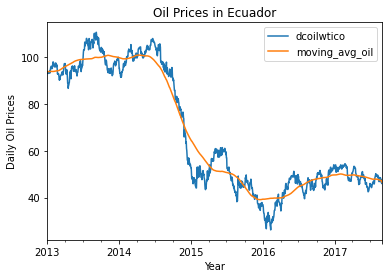

In [34]:
df_moving_avg_oil['date'] = pd.to_datetime(df_moving_avg_oil['date'])
df_moving_avg_oil['Year'] = df_moving_avg_oil['date'].dt.year

df_moving_avg_oil.plot.line(x='date', y=['dcoilwtico', 'moving_avg_oil'])

plt.xlabel('Year')
plt.ylabel('Daily Oil Prices')
plt.title("Oil Prices in Ecuador")

plt.show()

In [35]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,holiday_type,locale,locale_name,description,transferred,city,state,store_type,cluster,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,NaN
1,1,2013-01-01,1,BABY CARE,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,NaN
2,2,2013-01-01,1,BEAUTY,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,NaN
3,3,2013-01-01,1,BEVERAGES,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,NaN
4,4,2013-01-01,1,BOOKS,0.0,0,Holiday,National,Ecuador,Primer dia del ano,False,Quito,Pichincha,D,13,NaN


In [36]:
df['sales'] = df['sales'].replace(np.nan, int(0)) #Nan = 0 sales, store probably closed
df['transactions'] = df['transactions'].replace(np.nan, int(0)) #same as above
df['holiday_type'] = df['holiday_type'].replace({np.nan: 'Work Day', }) #not listed as a holiday, assuming Work Day
df['transferred'] = df['transferred'].replace(np.nan, 'False') #Given: A transferred day is more like a normal day than a holiday
#columns describing holidays are left as blank space for Work Days
df['locale'] = df['locale'].replace(np.nan, ' ')
df['locale_name'] = df['locale_name'].replace(np.nan, ' ')
df['description'] = df['description'].replace(np.nan, ' ')

In [37]:
df_moving_avg_oil=df_moving_avg_oil.drop(columns=['dcoilwtico','Year'])
df['date'] = pd.to_datetime(df['date'])
df = df.merge(df_moving_avg_oil, on='date', how='left')

In [38]:
df.isnull().sum()

id                     0
date                   0
store_nbr              0
family                 0
sales                  0
onpromotion            0
holiday_type           0
locale                 0
locale_name            0
description            0
transferred            0
city                   0
state                  0
store_type             0
cluster                0
transactions           0
moving_avg_oil    878526
dtype: int64

In [25]:
bool_series = pd.isnull(df["moving_avg_oil"])
 
# filtering data
# displaying data only with team = NaN
df[bool_series]

,id,date,store_nbr,family,sales,onpromotion,holiday_type,locale,locale_name,description,transferred,city,state,store_type,cluster,transactions,moving_avg_oil,Year
7128,7128,2013-01-05,1,AUTOMOTIVE,5.000,0,Work Day,National,Ecuador,Recupero puente Navidad,False,Quito,Pichincha,D,13,1509.0,NaN,2013
7129,7129,2013-01-05,1,BABY CARE,0.000,0,Work Day,National,Ecuador,Recupero puente Navidad,False,Quito,Pichincha,D,13,1509.0,NaN,2013
7130,7130,2013-01-05,1,BEAUTY,3.000,0,Work Day,National,Ecuador,Recupero puente Navidad,False,Quito,Pichincha,D,13,1509.0,NaN,2013
7131,7131,2013-01-05,1,BEVERAGES,1160.000,0,Work Day,National,Ecuador,Recupero puente Navidad,False,Quito,Pichincha,D,13,1509.0,NaN,2013
7132,7132,2013-01-05,1,BOOKS,0.000,0,Work Day,National,Ecuador,Recupero puente Navidad,False,Quito,Pichincha,D,13,1509.0,NaN,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3050779,2997319,2017-08-13,9,POULTRY,412.458,0,Work Day,,,,False,Quito,Pichincha,B,6,1745.0,NaN,2017
3050780,2997320,2017-08-13,9,PREPARED FOODS,105.169,1,Work Day,,,,False,Quito,Pichincha,B,6,1745.0,NaN,2017
3050781,2997321,2017-08-13,9,PRODUCE,1693.607,7,Work Day,,,,False,Quito,Pichincha,B,6,1745.0,NaN,2017
3050782,2997322,2017-08-13,9,SCHOOL AND OFFICE SUPPLIES,200.000,8,Work Day,,,,False,Quito,Pichincha,B,6,1745.0,NaN,2017


#to reduce computation time, I could select only the families that contribte most notable to total sales. (Not moving forwards with right now)
family_sales = df.groupby('family').sum()['sales'].sort_values(ascending=False)
df_family_sales = pd.DataFrame(family_sales)
df_family_sales = df_family_sales.reset_index()
#f_family_sales.plot(kind='bar');
#Seafood will be the first category not encoded.
#f_family_sales.head(16)

main_fams = df_family_sales.loc[0:14, 'family']

In [22]:
df = df.set_index('date').to_period('D') #important to set the period frequency to get out_of_sample forecast dates after origin

In [56]:
df.tail()

,id,date,store_nbr,family,sales,onpromotion,holiday_type,locale,locale_name,description,transferred,city,state,store_type,cluster,transactions,moving_avg_oil
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,B,6,2155.0,47.595859
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,B,6,2155.0,47.595859
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,B,6,2155.0,47.595859
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,B,6,2155.0,47.595859
3054347,3000887,2017-08-15,9,SEAFOOD,16.000,0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,Quito,Pichincha,B,6,2155.0,47.595859


In [12]:
from sklearn.linear_model import LinearRegression
#Average Sales
average_sales = df.groupby('date').mean()['sales']
average_sales_train = average_sales.loc[:'2017-08-15']
df_avgSales = average_sales_train.to_frame()
#Time Dummy: from time index to model time dependance as a feature
time_dummy = np.arange(len(df_avgSales.index))
df_avgSales['time_dummy'] = time_dummy
X = df_avgSales.loc[:,['time_dummy']] #feature - df
y = df_avgSales.loc[:,'sales'] #target - Series
model = LinearRegression()
model.fit(X,y)
y_pred = pd.Series(model.predict(X), index=X.index)

In [13]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,)

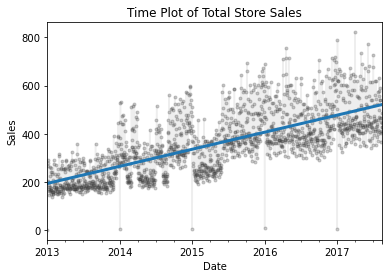

In [14]:
ax = y.plot(**plot_params, alpha=0.25)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales')
ax.set_xlabel('Date')
ax.set_ylabel('Sales');

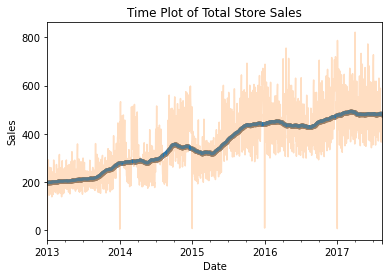

In [15]:
#Finding the trend
trend = y.rolling(
    window=200,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=100,  # choose about half the window size
).mean()              #MEDIAN SEEMS TO CAPTURE THE END BETTER...? 

ax = trend.plot(style=".", color="0.5")
trend.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);
ax = y.plot(alpha=0.25)
ax.set_title('Time Plot of Total Store Sales')
ax.set_xlabel('Date')
ax.set_ylabel('Sales');

In [16]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess #CalendarFourier used later
y = average_sales_train.copy()  # the target
# YOUR CODE HERE: Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=3,
    drop=True
)
#Feature set for the dates given in y.index
X = dp.in_sample()
#90-day forecast.
X_fore = dp.out_of_sample(steps=90)

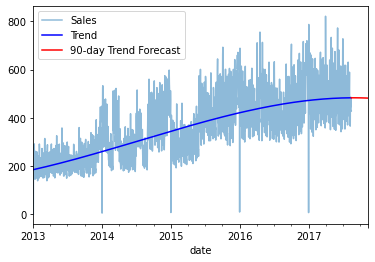

In [17]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(alpha=0.5, label='Sales')
ax = y_pred.plot(ax=ax, label="Trend", color='blue')
x = y_fore.plot(ax=ax, label="90-day Trend Forecast", color='red')
ax.legend();
#COULD TRY USING SPLINES FOR A BETTER TREND pyearth

In [18]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
#Periodogram to determine # of Fourier signals needed to match the frequency
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts, #time series
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual", #1
            "Semiannual", #2
            "Quarterly", #4
            "Bimonthly", #6
            "Monthly", #12
            "Biweekly", #26
            "Weekly", #52
            "Semiweekly", #104
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

C:\Users\adeli\AppData\Local\Temp/ipykernel_18792/930219591.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  plot_periodogram(average_sales_train);


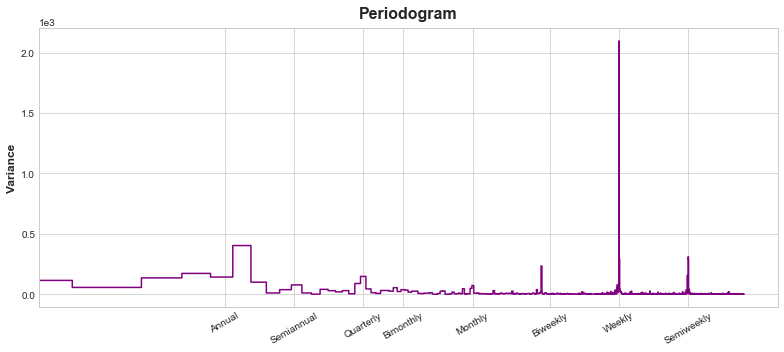

In [19]:
plot_periodogram(average_sales_train);

In [20]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

## Seasonality - Seasonal Indicators

<AxesSubplot:title={'center':'Seasonal Plot (year/day_of_year)'}, xlabel='day_of_year', ylabel='sales'>

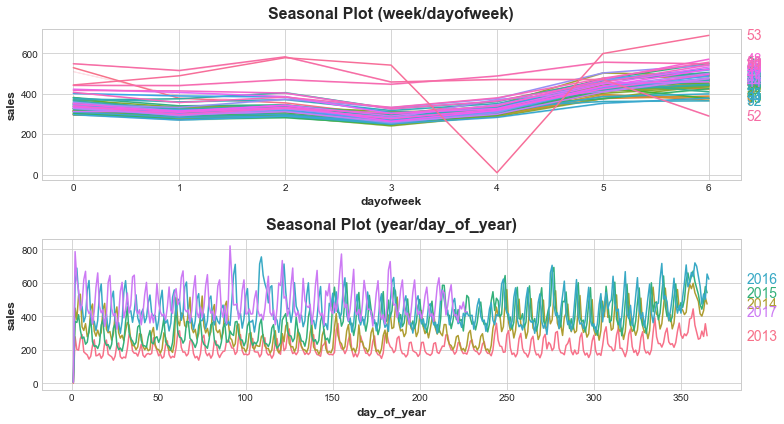

In [21]:
X = df_avgSales.copy()

# days within a week
X["dayofweek"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["day_of_year"] = X.index.day_of_year
X["year"] = X.index.year

#Weekly & Annual Seasonality yr-over-yr
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="sales", period="week", freq="dayofweek", ax=ax0)
seasonal_plot(X, y="sales", period="year", freq="day_of_year", ax=ax1)

<AxesSubplot:title={'center':'Seasonal Plot (week/dayofweek)'}, xlabel='dayofweek', ylabel='sales'>

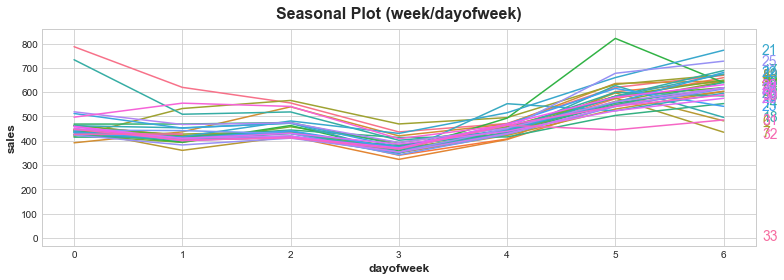

In [31]:
X = df_avgSales.copy()
X = X.groupby('date').sum().squeeze().loc['2017']

# days within a week
X["dayofweek"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

#Weekly Seasonality for year 2017
fig, (ax) = plt.subplots(1, 1, figsize=(11, 4))
seasonal_plot(X, y="sales", period="week", freq="dayofweek", ax=ax)

In [32]:
#CREATE COLUMN INDICATORS FOR WEEKLY SEASONALITY (FIT TREND TO DATA ABOVE)
weekly_indicators = X.loc[:,['sales']]
weekly_indicators['dayOfWeek'] = weekly_indicators.index.dayofweek
days = {0:'Mon', 1:'Tues', 2:'Wed', 3:'Thurs', 4:'Fri', 5:'Sat', 6:'Sun'}
weekly_indicators['dayOfWeek'] = weekly_indicators['dayOfWeek'].apply(lambda x: days[x])

In [33]:
from sklearn.preprocessing import OneHotEncoder
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_weekdays = pd.DataFrame(OH_encoder.fit_transform(weekly_indicators[['dayOfWeek']]))
OH_weekdays.index = weekly_indicators.index
OH_weekdays = OH_weekdays.rename(columns=days)

In [34]:
days

{0: 'Mon', 1: 'Tues', 2: 'Wed', 3: 'Thurs', 4: 'Fri', 5: 'Sat', 6: 'Sun'}

In [35]:
weekly_indicators = weekly_indicators.merge(OH_weekdays, on='date', how='inner')
weekly_indicators.drop(columns='dayOfWeek')

,sales,Mon,Tues,Wed,Thurs,Fri,Sat,Sun
date,,,,,,,,
2017-01-01,6.780304,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-01-02,786.928379,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2017-01-03,619.740224,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-01-04,555.608004,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017-01-05,436.375395,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2017-08-11,463.733851,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-12,444.798280,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2017-08-13,485.768618,0.0,0.0,0.0,1.0,0.0,0.0,0.0


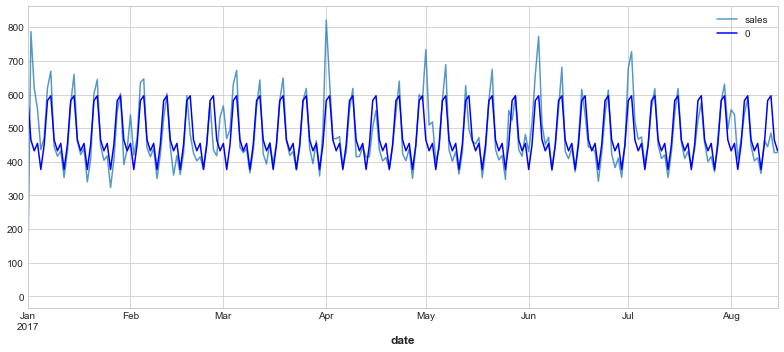

In [36]:
X_weekly_indicators = weekly_indicators[['Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']] #features
y = weekly_indicators['sales']
model = LinearRegression()
model.fit(X_weekly_indicators, y)

y_weekly_season = pd.DataFrame(model.predict(X_weekly_indicators), index=X_weekly_indicators.index)

ax = y.plot(alpha=0.75, label='sales')
ax = y_weekly_season.plot(ax=ax, label="Trend", color='blue')
ax.legend();

In [37]:
X = X.merge(y_weekly_season, on='date', how='inner')
X = X.rename(columns={0:'weekly_sales_trend'})
X

,sales,time_dummy,dayofweek,week,weekly_sales_trend
date,,,,,
2017-01-01,6.780304,1457,6,52,596.172174
2017-01-02,786.928379,1458,0,1,465.263154
2017-01-03,619.740224,1459,1,1,432.757792
2017-01-04,555.608004,1460,2,1,454.808598
2017-01-05,436.375395,1461,3,1,377.217399
...,...,...,...,...,...
2017-08-11,463.733851,1679,4,32,450.898361
2017-08-12,444.798280,1680,5,32,582.071919
2017-08-13,485.768618,1681,6,32,596.172174


In [38]:
y = X['sales']
# YOUR CODE HERE
fourier = CalendarFourier(freq="M", order=4) # 4 sin/cos pairs for "M"onthly seasonality
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample() 

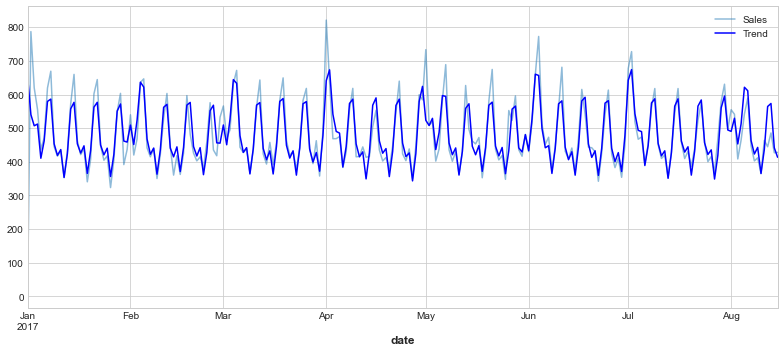

In [39]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(alpha=0.5, label='Sales')
ax = y_pred.plot(ax=ax, label="Trend", color='blue')
ax.legend();